**Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.**

In [1]:
import warnings
warnings.simplefilter("ignore")

import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

from scipy.stats import gmean, rankdata

In [2]:
client_profile = pd.read_csv('data/client_profile.csv')
client_profile.head(2)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
test = pd.read_csv('data/test.csv')
test.head(2)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash


In [4]:
train = pd.read_csv('data/train.csv')
train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash


In [5]:
train_index = train['APPLICATION_NUMBER']
test_index = test['APPLICATION_NUMBER']

In [6]:
train = train.merge(client_profile, on='APPLICATION_NUMBER', how='left')
test = test.merge(client_profile, on='APPLICATION_NUMBER', how='left')

In [7]:
train.shape

(110093, 26)

In [8]:
test.shape

(165141, 25)

In [9]:
target = train['TARGET']

In [10]:
train = train.drop(['APPLICATION_NUMBER', 'TARGET'], axis=1)
test = test.drop(['APPLICATION_NUMBER'], axis=1)

In [11]:
def encode_labels(df):
    categorical_cols = df.select_dtypes(include="object")
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].fillna('null'))
        
    return df

In [12]:
train = encode_labels(train)
test = encode_labels(test)

In [13]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

#     if categorical:
#         for feature in categorical:
#             encoder = LabelEncoder()
#             X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=100,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)
    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)

    return estimators, oof_preds

In [14]:
xgb_params = {

    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 100000,
    "max_depth": 5,
    "seed": 99,
    'grow_policy': 'lossguide',
    'max_leaves' : 1000
}
cv_strategy = KFold(n_splits=7, random_state=49, shuffle=True)

In [15]:
estimators_xgb, oof_score_xgb = xgboost_cross_validation(
    xgb_params, train, target,  cv=cv_strategy
)

Sun Dec 20 23:58:47 2020, Cross-Validation, 110093 rows, 24 cols
[23:58:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69004	valid-auc:0.68153
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.70998	valid-auc:0.69963
[200]	train-auc:0.71999	valid-auc:0.70749
[300]	train-auc:0.72973	valid-auc:0.71437
[400]	train-auc:0.73937	valid-auc:0.71898
[500]	train-auc:0.74654	valid-auc:0.72159
[600]	train-auc:0.75214	valid-auc:0.72232
[700]	train-auc:0.75704	valid-auc:0.72391
[800]	train-auc:0.76096	valid-auc:0.72383
Stopping. Best iteration:

In [16]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """

            
    estimators, folds_scores = [], []
    
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", 
            verbose=500, 
            early_stopping_rounds=500
        )
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
#         print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    return estimators, oof_preds

In [17]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.01,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
       
}

In [18]:
estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, train, target, cv=cv_strategy, 
)

Mon Dec 21 00:02:35 2020, Cross-Validation, 110093 rows, 24 cols
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.725461
Early stopping, best iteration is:
[314]	valid_0's auc: 0.726102
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.71323
[1000]	valid_0's auc: 0.715237
[1500]	valid_0's auc: 0.715832
[2000]	valid_0's auc: 0.716087
Early stopping, best iteration is:
[1612]	valid_0's auc: 0.716619
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.721694
[1000]	valid_0's auc: 0.723177
Early stopping, best iteration is:
[994]	valid_0's auc: 0.723295
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.729611
[1000]	valid_0's auc: 0.72874
Early stopping, best iteration is:
[715]	valid_0's auc: 0.7306
Training until validation scores don't improve for 500 rounds
[500]	valid_0's auc: 0.724411
[1000]	valid_0's auc: 0.723944
Early stopping, best iteration i

In [19]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb": oof_score_xgb    
})

corr = scores.corr()

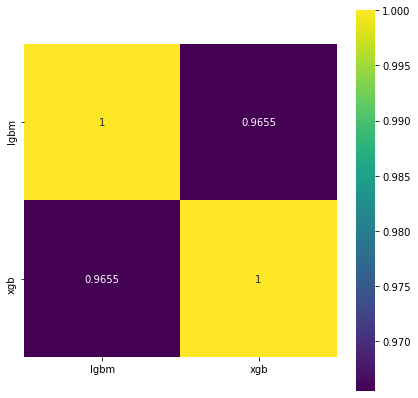

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [21]:
prediction_xgb = np.zeros(test.shape[0])
for model in estimators_xgb:
    prediction_xgb+=model.predict(xgb.DMatrix(test))
prediction_xgb = prediction_xgb/len(estimators_xgb)

In [22]:
prediction_lxbm = np.zeros(test.shape[0])
for model in estimators_lgbm:
    prediction_lxbm+=model.predict_proba(test)[:, 1]
            
prediction_lxbm = prediction_lxbm/len(estimators_lgbm)

In [23]:
scores_preds = pd.DataFrame({
    "lgbm": prediction_lxbm,
    "xgb": prediction_xgb    
})

corr = scores_preds.corr()

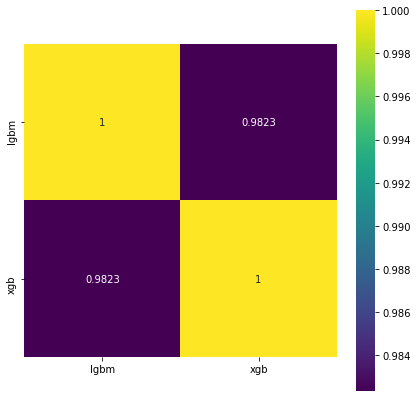

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция 2 моделей на трейне и тесте = 0,9655 и 0,9823 соответсвенно. Цифра немного велика, но тем не менее ниже 0,99, что опускает построение стекинга или бленндинга с использованием этих моделей 

**Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации**

##### AMean

In [25]:
scores_mean = scores.mean(axis=1)

score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7218


##### GMean

In [26]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7219


##### Rankdata

In [27]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7215


In [28]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7215


Геометрической среднее показывает лучший результат - 0,7219, худший - rankdata = 0.6375
При этом GMean показывает значение на 0,0011 хуже, чем средний скор по фолдам на Lightgbm  и на 0,0021 лучше, чем на XGBoost.
Думаю, что при блендинге можно указать 0,7*prediction_lxbm + 0,3*prediction_xgb

**Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.**

In [29]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)
    return estimators, oof_preds

In [30]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}



estimators_cb, oof_preds_cb = catboost_cross_validation(
    params=cb_params, X=train, y=target, cv=cv_strategy
)

Mon Dec 21 00:03:50 2020, Cross-Validation, 110093 rows, 24 cols
0:	test: 0.6420667	test1: 0.6355116	best: 0.6355116 (0)	total: 80.6ms	remaining: 2m 41s
10:	test: 0.6876216	test1: 0.6844172	best: 0.6880657 (8)	total: 304ms	remaining: 55s
20:	test: 0.6915097	test1: 0.6909818	best: 0.6913542 (17)	total: 534ms	remaining: 50.3s
30:	test: 0.6943670	test1: 0.6940390	best: 0.6950259 (28)	total: 760ms	remaining: 48.3s
40:	test: 0.6970304	test1: 0.6971347	best: 0.6971347 (40)	total: 980ms	remaining: 46.8s
50:	test: 0.6990430	test1: 0.6986459	best: 0.6994905 (49)	total: 1.2s	remaining: 46s
60:	test: 0.7003929	test1: 0.7009670	best: 0.7014656 (56)	total: 1.43s	remaining: 45.5s
70:	test: 0.7016991	test1: 0.7022897	best: 0.7024128 (66)	total: 1.66s	remaining: 45s
80:	test: 0.7027785	test1: 0.7035804	best: 0.7035804 (80)	total: 1.87s	remaining: 44.4s
90:	test: 0.7030507	test1: 0.7023099	best: 0.7039380 (82)	total: 2.09s	remaining: 43.9s
100:	test: 0.7042499	test1: 0.7041238	best: 0.7044034 (98)	tota

910:	test: 0.7341868	test1: 0.7253941	best: 0.7255957 (885)	total: 20.8s	remaining: 24.8s
920:	test: 0.7344773	test1: 0.7256047	best: 0.7256544 (919)	total: 21s	remaining: 24.6s
930:	test: 0.7346129	test1: 0.7253744	best: 0.7256544 (919)	total: 21.2s	remaining: 24.4s
940:	test: 0.7348868	test1: 0.7255032	best: 0.7256544 (919)	total: 21.5s	remaining: 24.2s
950:	test: 0.7350731	test1: 0.7255117	best: 0.7256695 (947)	total: 21.7s	remaining: 23.9s
960:	test: 0.7352870	test1: 0.7255846	best: 0.7256695 (947)	total: 21.9s	remaining: 23.7s
970:	test: 0.7355861	test1: 0.7253457	best: 0.7256695 (947)	total: 22.1s	remaining: 23.5s
980:	test: 0.7358831	test1: 0.7255036	best: 0.7256695 (947)	total: 22.4s	remaining: 23.2s
990:	test: 0.7360848	test1: 0.7255838	best: 0.7256695 (947)	total: 22.6s	remaining: 23s
1000:	test: 0.7363098	test1: 0.7257271	best: 0.7257271 (1000)	total: 22.8s	remaining: 22.8s
1010:	test: 0.7365087	test1: 0.7257899	best: 0.7257899 (1010)	total: 23.1s	remaining: 22.5s
1020:	test

380:	test: 0.7210759	test1: 0.7104949	best: 0.7105679 (377)	total: 8.39s	remaining: 35.7s
390:	test: 0.7213430	test1: 0.7107257	best: 0.7108563 (389)	total: 8.62s	remaining: 35.5s
400:	test: 0.7217228	test1: 0.7105921	best: 0.7109002 (397)	total: 8.84s	remaining: 35.3s
410:	test: 0.7221256	test1: 0.7109865	best: 0.7109865 (410)	total: 9.07s	remaining: 35.1s
420:	test: 0.7224229	test1: 0.7111395	best: 0.7111395 (420)	total: 9.29s	remaining: 34.8s
430:	test: 0.7227616	test1: 0.7114517	best: 0.7114970 (428)	total: 9.51s	remaining: 34.6s
440:	test: 0.7231900	test1: 0.7112091	best: 0.7117537 (433)	total: 9.73s	remaining: 34.4s
450:	test: 0.7236330	test1: 0.7112343	best: 0.7117537 (433)	total: 9.96s	remaining: 34.2s
460:	test: 0.7240539	test1: 0.7112927	best: 0.7117537 (433)	total: 10.2s	remaining: 34s
470:	test: 0.7244971	test1: 0.7115201	best: 0.7117537 (433)	total: 10.4s	remaining: 33.8s
480:	test: 0.7246383	test1: 0.7114356	best: 0.7117537 (433)	total: 10.6s	remaining: 33.5s
490:	test: 0

520:	test: 0.7240741	test1: 0.7204765	best: 0.7204765 (520)	total: 11s	remaining: 31.4s
530:	test: 0.7245412	test1: 0.7204419	best: 0.7205204 (522)	total: 11.3s	remaining: 31.1s
540:	test: 0.7249239	test1: 0.7207061	best: 0.7208031 (537)	total: 11.5s	remaining: 30.9s
550:	test: 0.7251656	test1: 0.7208168	best: 0.7208453 (547)	total: 11.7s	remaining: 30.7s
560:	test: 0.7254805	test1: 0.7209538	best: 0.7209538 (560)	total: 11.9s	remaining: 30.5s
570:	test: 0.7258270	test1: 0.7212931	best: 0.7212974 (569)	total: 12.1s	remaining: 30.3s
580:	test: 0.7261155	test1: 0.7217299	best: 0.7217636 (578)	total: 12.3s	remaining: 30.1s
590:	test: 0.7264812	test1: 0.7219198	best: 0.7219198 (590)	total: 12.5s	remaining: 29.9s
600:	test: 0.7268171	test1: 0.7217999	best: 0.7219198 (590)	total: 12.8s	remaining: 29.7s
610:	test: 0.7271627	test1: 0.7219671	best: 0.7220847 (609)	total: 13s	remaining: 29.5s
620:	test: 0.7275278	test1: 0.7221145	best: 0.7221424 (614)	total: 13.2s	remaining: 29.3s
630:	test: 0.7

440:	test: 0.7207582	test1: 0.7220837	best: 0.7221626 (433)	total: 9.32s	remaining: 32.9s
450:	test: 0.7214588	test1: 0.7222892	best: 0.7224662 (448)	total: 9.53s	remaining: 32.7s
460:	test: 0.7218312	test1: 0.7229296	best: 0.7229296 (460)	total: 9.75s	remaining: 32.6s
470:	test: 0.7221666	test1: 0.7228476	best: 0.7229296 (460)	total: 9.97s	remaining: 32.4s
480:	test: 0.7223762	test1: 0.7229241	best: 0.7230503 (479)	total: 10.2s	remaining: 32.1s
490:	test: 0.7226542	test1: 0.7231045	best: 0.7231627 (489)	total: 10.4s	remaining: 31.9s
500:	test: 0.7231186	test1: 0.7232547	best: 0.7234361 (498)	total: 10.6s	remaining: 31.8s
510:	test: 0.7234154	test1: 0.7234982	best: 0.7234982 (510)	total: 10.8s	remaining: 31.5s
520:	test: 0.7236080	test1: 0.7236422	best: 0.7236768 (517)	total: 11s	remaining: 31.4s
530:	test: 0.7240254	test1: 0.7237346	best: 0.7237360 (529)	total: 11.3s	remaining: 31.1s
540:	test: 0.7242773	test1: 0.7236815	best: 0.7237360 (529)	total: 11.5s	remaining: 30.9s
550:	test: 0

430:	test: 0.7215101	test1: 0.7160076	best: 0.7160076 (430)	total: 9.41s	remaining: 34.2s
440:	test: 0.7219436	test1: 0.7159251	best: 0.7160611 (432)	total: 9.63s	remaining: 34s
450:	test: 0.7223600	test1: 0.7164966	best: 0.7164966 (450)	total: 9.85s	remaining: 33.8s
460:	test: 0.7226207	test1: 0.7166958	best: 0.7167152 (458)	total: 10.1s	remaining: 33.6s
470:	test: 0.7230103	test1: 0.7164886	best: 0.7167950 (462)	total: 10.3s	remaining: 33.4s
480:	test: 0.7232305	test1: 0.7166946	best: 0.7167950 (462)	total: 10.5s	remaining: 33.2s
490:	test: 0.7237342	test1: 0.7171073	best: 0.7171073 (490)	total: 10.7s	remaining: 33s
500:	test: 0.7239907	test1: 0.7171081	best: 0.7172099 (494)	total: 11s	remaining: 32.8s
510:	test: 0.7242261	test1: 0.7173257	best: 0.7173257 (510)	total: 11.2s	remaining: 32.6s
520:	test: 0.7245936	test1: 0.7173712	best: 0.7174034 (518)	total: 11.4s	remaining: 32.4s
530:	test: 0.7249302	test1: 0.7175434	best: 0.7176355 (528)	total: 11.6s	remaining: 32.2s
540:	test: 0.725

640:	test: 0.7296163	test1: 0.7126346	best: 0.7126796 (628)	total: 13.7s	remaining: 29.1s
650:	test: 0.7297491	test1: 0.7129090	best: 0.7129259 (648)	total: 13.9s	remaining: 28.9s
660:	test: 0.7301000	test1: 0.7129664	best: 0.7129718 (659)	total: 14.2s	remaining: 28.7s
670:	test: 0.7303720	test1: 0.7127719	best: 0.7131055 (668)	total: 14.4s	remaining: 28.5s
680:	test: 0.7306283	test1: 0.7130938	best: 0.7131055 (668)	total: 14.6s	remaining: 28.2s
690:	test: 0.7308863	test1: 0.7129186	best: 0.7131239 (683)	total: 14.8s	remaining: 28s
700:	test: 0.7312266	test1: 0.7130192	best: 0.7131239 (683)	total: 15s	remaining: 27.8s
710:	test: 0.7315592	test1: 0.7131207	best: 0.7132667 (709)	total: 15.2s	remaining: 27.6s
720:	test: 0.7317333	test1: 0.7134415	best: 0.7134443 (719)	total: 15.4s	remaining: 27.4s
730:	test: 0.7319253	test1: 0.7136178	best: 0.7137397 (726)	total: 15.6s	remaining: 27.2s
740:	test: 0.7321810	test1: 0.7137305	best: 0.7137462 (731)	total: 15.9s	remaining: 26.9s
750:	test: 0.7

1550:	test: 0.7488273	test1: 0.7194808	best: 0.7196610 (1537)	total: 33.4s	remaining: 9.66s
1560:	test: 0.7490129	test1: 0.7193704	best: 0.7196610 (1537)	total: 33.6s	remaining: 9.44s
1570:	test: 0.7491793	test1: 0.7194470	best: 0.7196610 (1537)	total: 33.8s	remaining: 9.23s
1580:	test: 0.7492755	test1: 0.7195589	best: 0.7196610 (1537)	total: 34s	remaining: 9.02s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7196609658
bestIteration = 1537

Shrink model to first 1538 iterations.
Fold 6, Valid score = 0.71966
0:	test: 0.6469168	test1: 0.6409734	best: 0.6409734 (0)	total: 21.1ms	remaining: 42.2s
10:	test: 0.6865197	test1: 0.6793721	best: 0.6796545 (6)	total: 227ms	remaining: 41s
20:	test: 0.6938916	test1: 0.6823263	best: 0.6823263 (20)	total: 433ms	remaining: 40.8s
30:	test: 0.6990309	test1: 0.6867611	best: 0.6867611 (30)	total: 642ms	remaining: 40.8s
40:	test: 0.6999580	test1: 0.6869048	best: 0.6884025 (39)	total: 841ms	remaining: 40.2s
50:	test: 0.7011652	test1: 0

860:	test: 0.7350356	test1: 0.7114365	best: 0.7115992 (856)	total: 18.4s	remaining: 24.3s
870:	test: 0.7352750	test1: 0.7113627	best: 0.7115992 (856)	total: 18.6s	remaining: 24.1s
880:	test: 0.7354812	test1: 0.7117168	best: 0.7117168 (880)	total: 18.8s	remaining: 23.9s
890:	test: 0.7356971	test1: 0.7119041	best: 0.7119041 (890)	total: 19s	remaining: 23.7s
900:	test: 0.7358536	test1: 0.7117875	best: 0.7119041 (890)	total: 19.2s	remaining: 23.5s
910:	test: 0.7360149	test1: 0.7119740	best: 0.7119740 (910)	total: 19.5s	remaining: 23.3s
920:	test: 0.7363142	test1: 0.7120015	best: 0.7120015 (920)	total: 19.7s	remaining: 23.1s
930:	test: 0.7364617	test1: 0.7121202	best: 0.7121252 (927)	total: 19.9s	remaining: 22.8s
940:	test: 0.7366565	test1: 0.7120630	best: 0.7121475 (932)	total: 20.1s	remaining: 22.6s
950:	test: 0.7368339	test1: 0.7120972	best: 0.7121601 (946)	total: 20.3s	remaining: 22.4s
960:	test: 0.7369787	test1: 0.7121528	best: 0.7121601 (946)	total: 20.5s	remaining: 22.2s
970:	test: 0

In [31]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb": oof_score_xgb,
    "cb": oof_preds_cb 
})

corr = scores.corr()

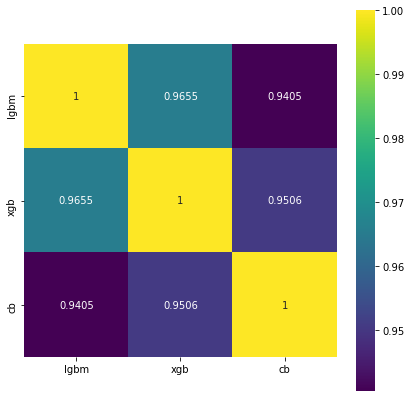

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [33]:
prediction_cb = np.zeros(test.shape[0])
for model in estimators_cb:
    prediction_cb+=model.predict_proba(test)[:, 1]
prediction_cb = prediction_cb/len(estimators_cb)

In [34]:
prediction_cb

array([0.07522362, 0.2184022 , 0.19380078, ..., 0.084866  , 0.03777066,
       0.05914905])

In [35]:
scores_preds = pd.DataFrame({
    "lgbm": prediction_lxbm,
    "xgb": prediction_xgb,
    "cb": prediction_cb  
})

corr = scores_preds.corr()

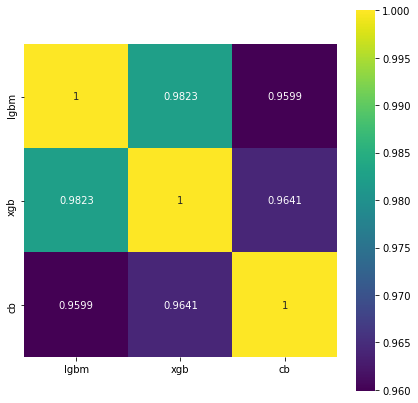

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(corr, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Корреляция моделей для обучающей и тестовой выборок достаточно неплохая, чтобы делать блендинг.

**Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.**

##### AMean

In [37]:
scores_mean = scores.mean(axis=1)

score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7225


##### GMean

In [38]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7224


##### Rankdata

In [39]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7222


In [40]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7222


Лучший результат для среднего арифметического. При этом сумма трех моделей показывает лучший результат, чем сумма 2 моделей. 
На 0,0005 хуже, чем lgbm, но на 0,0028 и на 0,0092 лучше, чем xgb и cb соответственно

Можно попробовать подобрать веса и сложить пресказания.

**Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [42]:
pipeline = Pipeline(
    steps=[
        ("scaling", StandardScaler()),
        ("estimator", LogisticRegression(random_state=1, solver="liblinear"))
    ]
)

In [43]:
x_train, x_valid, y_train, y_valid = train_test_split(
    scores, target, train_size=0.75, shuffle=True, random_state=25,
)

In [44]:
train_scores, valid_scores = [], []

params_grid = {
    "penalty": ["l1", "l2"],
    "C": [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
}

for penalty in params_grid["penalty"]:
    scores_penalty_train, scores_penalty_valid = [], []
    pipeline.named_steps["estimator"].penalty = penalty
    for c in params_grid["C"]:
        pipeline.named_steps["estimator"].C = c
        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict_proba(x_train)[:, 1]
        valid_pred = pipeline.predict_proba(x_valid)[:, 1]

        scores_penalty_train.append(
            roc_auc_score(y_train, train_pred)
        )
        scores_penalty_valid.append(
            roc_auc_score(y_valid, valid_pred)
        )

    train_scores.append(scores_penalty_train)
    valid_scores.append(scores_penalty_valid)

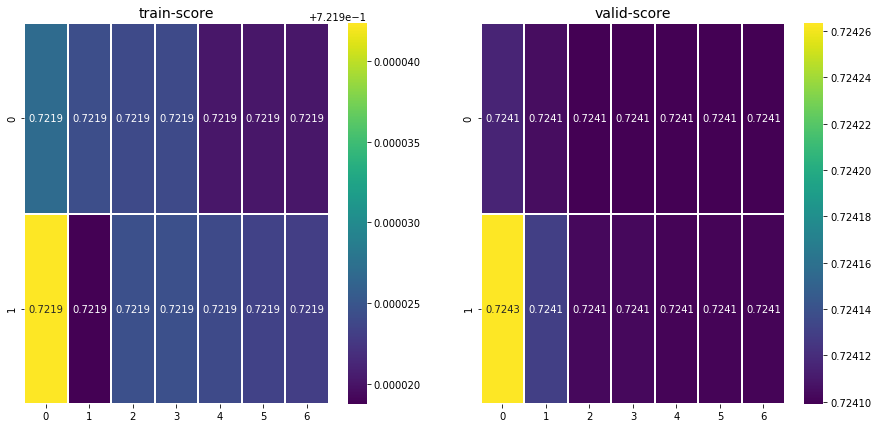

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].set_ylabel("penalty", fontsize=14)
axes[0].set_title("train-score", fontsize=14)
sns.heatmap(train_scores, annot=True, linewidths=1, fmt=".4g", cmap="viridis", ax=axes[0])

axes[1].set_ylabel("penalty", fontsize=14)
axes[1].set_title("valid-score", fontsize=14)
sns.heatmap(valid_scores, annot=True, linewidths=1, fmt=".4g", cmap="viridis", ax=axes[1])

In [51]:
def cross_validation(model, X, y, cv):
    """
    Кросс-валидация.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

  
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{sum(folds_scores)/len(folds_scores)}")
    print("="*65)
    return estimators, oof_preds

In [58]:
lr = LogisticRegression(random_state=42, solver="liblinear", C=10e-3)

estimators_lr, oof_preds_lr = cross_validation(model=lr,
                                               X=scores,
                                               y=target,
                                               cv=cv_strategy)

oof_preds_lr

Fold 1, Valid score = 0.72664
Fold 2, Valid score = 0.71567
Fold 3, Valid score = 0.72524
Fold 4, Valid score = 0.73182
Fold 5, Valid score = 0.72367
Fold 6, Valid score = 0.72025
Fold 7, Valid score = 0.7179
Score by each fold: [0.72664, 0.71567, 0.72524, 0.73182, 0.72367, 0.72025, 0.7179]
Mean score by each fold:0.7230271428571429


array([0.06028647, 0.08130052, 0.07588933, ..., 0.08119166, 0.0613361 ,
       0.08228039])

Качество лучше, чем усреднение предсказаний, но не лучше, чем чистая lgbm